In [ ]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# default_exp nn

# fulstream.nn

> Module to easily call basic neural networks made in jax.

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
#export
import jax.numpy as np
from jax.experimental import stax
from jax.experimental.stax import Dense, Relu, LogSoftmax
from jax import jit, grad, random
from jax.random import multivariate_normal, PRNGKey
from jax.config import config
from jax.experimental import optimizers

import numpy as onp
import numpy.random as npr
import itertools
import time
import matplotlib.pyplot as plt

In [ ]:
#export
def one_hot(x, k, dtype=np.float32):
    """Create a one-hot encoding of x of size k. Taken from jax/examples."""
    return np.array(x[:, None] == np.arange(k), dtype)

In [ ]:
#export
class simple_classifier:
    '''A simple classifier trained on separating two close normal distributions. Modelled after jax/examples/mnist_classifier.py.'''
    def __init__(self,rng=PRNGKey(0), dist=1):
        
        # Set up architecture
        self.init_random_params, self.predict = stax.serial(
        Dense(10), Relu,
        Dense(2), LogSoftmax)

        # save random seed and dist
        self.jrng = rng
        self.dist = dist
        
        # sample from two 2D gaussians that are dist apart in one dim
        sig = multivariate_normal(PRNGKey(1), np.asarray([2,5]), np.asarray([[1,0],[0,1]]),shape=(1,10000))[0]
        bkg = multivariate_normal(PRNGKey(1), np.asarray([2+dist,6]), np.asarray([[1,0],[0,1]]),shape=(1,10000))[0]
        # 1 = signal, 0 = background
        sig_lables = np.ones((1,10000))[0]
        bkg_lables = np.zeros((1,10000))[0]
        
        # create training data
        self.train_data = np.concatenate((sig,bkg))
        self.train_labels = one_hot(np.concatenate((sig_lables,bkg_lables)),2)
        
        # placeholder for neural network parameters
        self.params = []
    
    def __call__(self,x):
        return self.predict(self.params,x)
    
    def plot_train_data(self):
        plt.scatter(self.train_data[:,0], self.train_data[:,1],c=self.train_labels[:,0],alpha=0.2,s=1.4)
        plt.show()
        
    def train(self,step_size = 0.001,num_epochs = 3,batch_size = 16,momentum_mass = 0.9):
        '''Train the classifier using the specified hyperparameters.'''
        # set up batch number based on num of examples and batch_size
        num_train = self.train_data.shape[0]
        num_complete_batches, leftover = divmod(num_train, batch_size)
        num_batches = num_complete_batches + bool(leftover)

        # batching helper function
        def data_stream():
            rng = npr.RandomState(0)
            while True:
                perm = rng.permutation(num_train)
                for i in range(num_batches):
                    batch_idx = perm[i * batch_size:(i + 1) * batch_size]
                    yield self.train_data[batch_idx], self.train_labels[batch_idx]
                    
        # can call next(batches) to get a batch
        batches = data_stream()

        # set up momentum optimiser
        opt_init, opt_update, get_params = optimizers.momentum(step_size, mass=momentum_mass)
        
        # metrics:
        def loss(params, batch):
            inputs, targets = batch
            preds = self.predict(params, inputs)
            return -np.mean(np.sum(preds * targets, axis=1))

        def accuracy(params, batch):
            inputs, targets = batch
            target_class = np.argmax(targets, axis=1)
            predicted_class = np.argmax(self.predict(params, inputs), axis=1)
            return np.mean(predicted_class == target_class)

        # parameter update function
        @jit
        def update(i, opt_state, batch):
            params = get_params(opt_state)
            return opt_update(i, grad(loss)(params, batch), opt_state)

        _, init_params = self.init_random_params(self.jrng, (-1, 2))
        if self.params == []:
            opt_state = opt_init(init_params)
        else:
            opt_state = opt_init(self.params)
        itercount = itertools.count()
        
        # train loop
        print("\nStarting training...")
        for epoch in range(num_epochs):
            start_time = time.time()
            for _ in range(num_batches):
                opt_state = update(next(itercount), opt_state, next(batches))
                #print("Loss {}".format(loss(params,next(batches))))
            epoch_time = time.time() - start_time

            params = get_params(opt_state)
            train_acc = accuracy(params, (self.train_data, self.train_labels))
            #test_acc = accuracy(self.params, (test_data, test_labels))
            print("Epoch {} in {:0.2f} sec".format(epoch, epoch_time))
            print("Training set accuracy {}".format(train_acc))
            #print("Test set accuracy {}".format(test_acc))
            
        # keep trained parameters
        self.params = params
        
    def plot_decision(self,plot_data=False):
        '''Helper function to plot decision contours of classifier.'''
        delta = 0.05
        x = np.arange(-2.0, 11.0, delta)
        y = np.arange(0, 11.0, delta)
        X, Y = np.meshgrid(x, y)
        pairs = np.dstack([X, Y]).reshape(-1, 2)
        Z = np.exp(self.predict(self.params,pairs))[:,1].reshape(X.shape)
        fig, ax = plt.subplots()
        CS = ax.contourf(X, Y, Z,cmap='magma')
        ax.set_title('Decision contours of simple_classifier')
        if plot_data:
            ax.scatter(self.train_data[:,0], self.train_data[:,1],c=self.train_labels[:,0],alpha=0.2,s=1.4)
        plt.show()
    
    def gen_sig(self,nev,rng=PRNGKey(21)):
        return multivariate_normal(rng, np.asarray([2,5]), np.asarray([[1,0],[0,1]]),shape=(1,nev))[0]

    def gen_bkg(self,nev,rng=PRNGKey(22)):
        return multivariate_normal(rng, np.asarray([2+self.dist,5]), np.asarray([[1,0],[0,1]]),shape=(1,nev))[0]


In [ ]:
x = simple_classifier()

In [ ]:
x.train()


Starting training...
Epoch 0 in 4.21 sec
Training set accuracy 0.6785500049591064
Epoch 1 in 3.95 sec
Training set accuracy 0.7387999892234802
Epoch 2 in 3.94 sec
Training set accuracy 0.7506499886512756


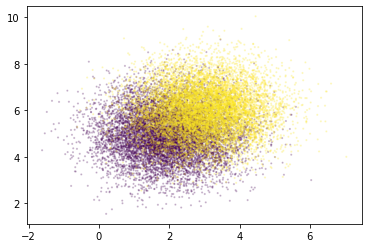

In [ ]:
x.plot_train_data()

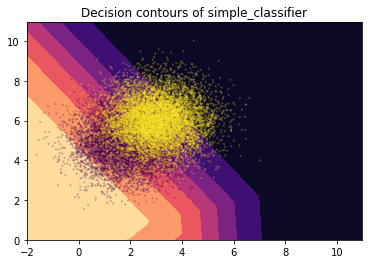

In [ ]:
x.plot_decision(True)

In [ ]:
#export
def hists_from_nn(nn, sigevents, bkgevents, scale=False, use_jax=True):
    '''Create nn-based binned summary statistics from signal and background events. nn must be callable.'''
    sig_sf = 0.02 if scale else 1 
    bkg_sf = 0.1 if scale else 1

    sighist = np.sum(np.exp(nn(sigevents)),axis=0)*sig_sf
    bkghist = np.sum(np.exp(nn(bkgevents)),axis=0)*bkg_sf
    
    if use_jax:
        return sighist, bkghist
    else:
        return onp.asarray(sighist), onp.asarray(bkghist)

In [ ]:
x = simple_classifier(dist=4)
x.train()


Starting training...
Epoch 0 in 4.12 sec
Training set accuracy 0.9330999851226807
Epoch 1 in 3.96 sec
Training set accuracy 0.9503999948501587
Epoch 2 in 3.65 sec
Training set accuracy 0.9623000025749207


In [ ]:
sighist, bkghist = hists_from_nn(x, x.gen_sig(1000), x.gen_bkg(1000), scale=True, use_jax=False) 

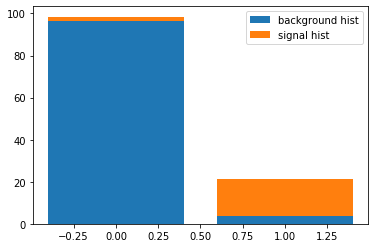

In [ ]:
plt.bar([0,1],bkghist, label='background hist')
plt.bar([0,1],sighist, bottom=bkghist, label='signal hist')
plt.legend()